In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Define the functions for Cumulative Prospect Theory (CPT) and hope-fear ratio

def gains_loss_value(x, alpha, beta):
    x_values = np.array(x)
    epsilon = 1e-8  # Small positive constant to avoid division by zero
    return np.where(x_values >= 0, np.log(1 + x_values)**alpha, np.sign(x_values) * (np.log(1 + (-x_values) + epsilon)**beta))

def probability_weighting(p, gamma):
    return np.where(np.array(p) >= 0, np.array(p)**gamma / (np.array(p)**gamma + (1 - np.array(p))**gamma)**(1/gamma), 0)

def decision_weight(x, p, alpha, beta, gamma):
    return gains_loss_value(np.array(x), alpha, beta) * probability_weighting(np.array(p), gamma)

def cpt_utility(x_values, probabilities, alpha, beta, gamma):
    epsilon = 1e-10  # Small constant to avoid division by zero
    x_values = np.array(x_values)

    gains_part = (probabilities * (np.maximum(x_values, 0)**alpha)).sum()
    losses_part = ((1 - probabilities) * ((-np.minimum(x_values, 0) + epsilon)**beta)).sum() + gamma

    return gains_part - losses_part

def hope_fear_ratio(outcomes, probabilities, alpha, beta, gamma):
    gains = np.maximum(outcomes, 0)
    losses = -np.minimum(outcomes, 0)

    gains_utility = cpt_utility(gains, probabilities, alpha, beta, gamma)
    losses_utility = cpt_utility(losses, probabilities, alpha, beta, gamma)

    if losses_utility == 0:
        return np.inf  # Set hope-fear ratio to infinity
    else:
        return gains_utility / losses_utility

# Define the portfolio optimization function

def optimize_portfolio(data, alpha, beta, gamma):
    log_returns = np.log(1 + data.pct_change().mean())
    cov_matrix = np.log(1 + data.pct_change().cov())

    num_assets = len(log_returns)

    def objective(weights):
        portfolio_return = np.dot(weights, log_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        portfolio_return_list = [portfolio_return]

        cpt_utility_value = cpt_utility(portfolio_return_list, np.array([1]), alpha, beta, gamma)
        hfr_value = hope_fear_ratio(portfolio_return_list, np.array([1]), alpha, beta, gamma)

        sharpe_ratio = portfolio_return / portfolio_volatility

        return -sharpe_ratio

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0.00000001, 1) for i in range(num_assets)]
    initial_guess = np.ones(num_assets) / num_assets

    result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    optimized_weights = result.x
    optimized_return = np.dot(optimized_weights, log_returns)
    optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
    cpt_utility_value = cpt_utility(optimized_return, np.array([1]), alpha, beta, gamma)
    hfr_value = hope_fear_ratio(optimized_return, np.array([1]), alpha, beta, gamma)

    # Calculate annualized values
    annualized_return = (((1 + optimized_return)** 252) - 1) * 100
    annualized_volatility = optimized_volatility * np.sqrt(252) * 100  # Assuming 252 trading days in a year

    sharpe_ratio_value = ((annualized_return - 0.01)/ annualized_volatility) if annualized_volatility != 0 else 0

    return optimized_weights, annualized_return, annualized_volatility, cpt_utility_value, hfr_value, sharpe_ratio_value

# Get data for the top 10 companies from the Indian market
indian_tickers = ['RELIANCE.NS','TCS.NS', 'HDFCBANK.NS','HINDUNILVR.NS', 'INFY.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'BHARTIARTL.NS', 'MARUTI.NS','HDB']
indian_data = yf.download(indian_tickers, start="2010-01-01", end="2021-01-01")['Adj Close']

# Specify the values of alpha, beta, and gamma
cpt_alpha = 0.88
cpt_beta = 0.88
cpt_gamma = 0.69

# Optimize the portfolio
optimized_weights, annualized_return, annualized_volatility, cpt_utility_value, hfr_value, sharpe_ratio_value = optimize_portfolio(indian_data, cpt_alpha, cpt_beta, cpt_gamma)

# Print the results
print('Optimized Weights:', optimized_weights)
print('Annualized Portfolio Return:', annualized_return)
print('Annualized Portfolio Volatility:', annualized_volatility)
print('CPT Utility:', cpt_utility_value)
print('Hope-fear ratio:', hfr_value)
print('Sharpe ratio:', sharpe_ratio_value)

#Store values
Annualized_returns_cpt = annualized_return
Annualized_volatility_cpt = annualized_volatility
Annualized_sharpe_cpt = sharpe_ratio_value

[*********************100%%**********************]  10 of 10 completed


Optimized Weights: [1.00000000e-08 1.79597961e-02 2.10667966e-01 3.35981311e-01
 1.00000000e-08 1.86507533e-02 9.66993751e-02 4.89863119e-02
 1.00000000e-08 2.71054457e-01]
Annualized Portfolio Return: 25.836942423401823
Annualized Portfolio Volatility: 16.41183200271915
CPT Utility: -0.6878867166828386
Hope-fear ratio: 0.9969372705548387
Sharpe ratio: 1.57367821088607


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [ ]:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbols for the top 10 Indian companies
ticker_symbols = ['RELIANCE.NS','TCS.NS', 'HDFCBANK.NS','HINDUNILVR.NS', 'INFY.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'BHARTIARTL.NS', 'MARUTI.NS','HDB']

# Download historical data for the specified tickers
data = yf.download(ticker_symbols, start="2010-01-01", end="2021-01-01")['Adj Close']

# Calculate daily returns
returns = data.pct_change()

# Calculate mean returns for each stock
mean_returns = returns.mean()

# Create an equally weighted portfolio
weights = [1 / len(ticker_symbols)] * len(ticker_symbols)

# Calculate portfolio returns
portfolio_returns = returns.dot(weights)

# Calculate annualized returns
annualized_returns = (((1 + portfolio_returns.mean()) ** 252) - 1)

# Calculate portfolio volatility
portfolio_volatility = returns.dot(weights).std()

# Calculate annualized volatility
annualized_volatility = portfolio_volatility * (252 ** 0.5)

# Set risk-free rate (you can update this value)
risk_free_rate = 0.01

# Calculate Sharpe ratio
sharpe_ratio = (annualized_returns - risk_free_rate) / annualized_volatility

# Print the results
print("Portfolio Statistics:")
print("----------------------")
print("Annualized Returns: {:.2%}".format(annualized_returns))
print("Volatility: {:.2%}".format(annualized_volatility))
print("Sharpe Ratio: {:.4f}".format(sharpe_ratio))

#Store Values
Annualized_returns_benchmark = annualized_returns*100
Annualized_volatility_benchmark = annualized_volatility*100
Annualized_sharpe_benchmark = sharpe_ratio

[*********************100%%**********************]  10 of 10 completed

Portfolio Statistics:
----------------------
Annualized Returns: 21.54%
Volatility: 17.09%
Sharpe Ratio: 1.2020


In [ ]:
pip install scikit-optimize

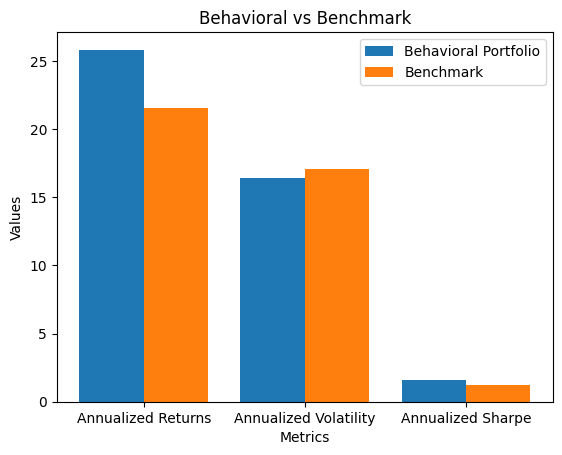

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = ['Annualized Returns','Annualized Volatility','Annualized Sharpe']
Y = [Annualized_returns_cpt,Annualized_volatility_cpt,Annualized_sharpe_cpt]
Z = [Annualized_returns_benchmark,Annualized_volatility_benchmark,Annualized_sharpe_benchmark]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Y, 0.4, label = 'Behavioral Portfolio')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Benchmark')

plt.xticks(X_axis, X)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Behavioral vs Benchmark")
plt.legend()
plt.show()


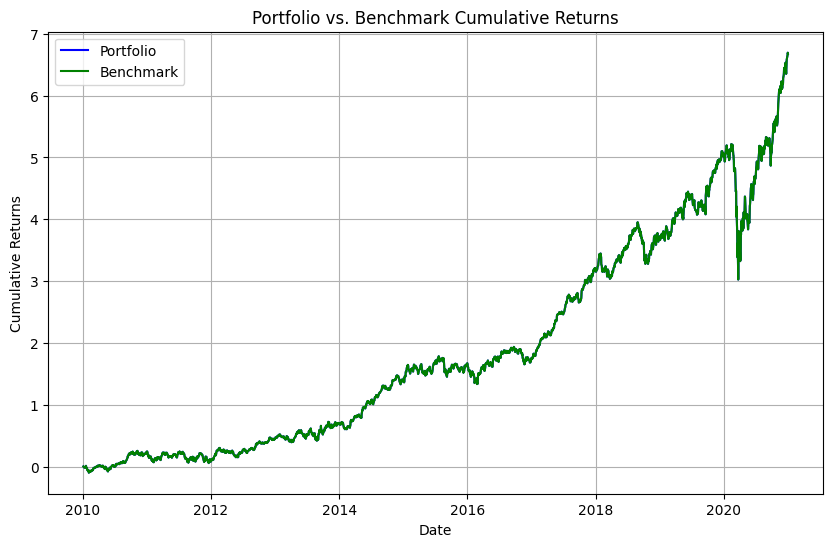

In [ ]:
# Calculate cumulative returns
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1
benchmark_cumulative_returns = (1 + returns.mean(axis=1)).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Portfolio', color='blue')
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Benchmark', color='green')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio vs. Benchmark Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()